In [6]:
import pymongo
from pprint import pprint
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Set, Tuple
import functools as ft
import numpy as np
import random
from spacy.tokens import DocBin
from tqdm import tqdm
from constants import utc_to_dt, COLL
import spacy
from explore_build import text_to_spacy
nlp = spacy.load("en_core_web_sm")

## Top N User Reddit Data

### 1. Load data from Mongo/Reddit

In [2]:
# read in data and filter missing text
users_df = pd.read_csv("data/top10_users.csv").dropna()

In [4]:
# convert text to spacy docs
text_docs = [t for t in users_df["text"].tolist() if type(t) == str]
spacy_docs = []
for t in tqdm(text_docs):
    spacy_docs.append(nlp(t))

100%|██████████| 174934/174934 [7:54:46<00:00,  6.14it/s]       


In [7]:
# write space docs to disk
doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"],
                 store_user_data=True)
for doc in tqdm(spacy_docs):
    doc_bin.add(doc)
    
# write bytes data to file
spacy_fp = "data/top10_spacy.spacy"
bytes_data = doc_bin.to_bytes()
out_f = open(spacy_fp, "wb")
out_f.write(bytes_data)

100%|██████████| 174934/174934 [00:20<00:00, 8541.04it/s] 


28832714

In [8]:
# sample read in of written docs
docbin = DocBin().from_bytes(open(spacy_fp, "rb").read())
disk_docs = docbin.get_docs(nlp.vocab)
disk_docsl = list(disk_docs)

In [19]:
# add spacy docs to users dataframe
temp_docs = disk_docsl.copy()
spacy_col = [temp_docs.pop() if type(t) == str else None for t in users_df["text"].tolist()]
users_df["spacy"] = spacy_col

### 2. User Plots

In [21]:
users_df.head()

,username,text,subreddit,is_sub,id,spacy
2,spinderella69,Selling NSFW content is no longer allowed on t...,FuckingTweakers,True,ffobso,"(Ugh, this, ., Honestly, if, I, had, to, give,..."
4,spinderella69,"Title says it all, admins have begun to ban su...",OpiateChurch,True,fcpa4w,"(Thanks, for, the, the, welcome, !, It, 's, re..."
5,spinderella69,This is just to remind everyone that sourcing ...,Stims,True,f0n20q,"(Yummy, hookup, !)"
6,spinderella69,This sub is not for finding drugs or a connect...,cracksmokers,True,ey1qdv,"(I, say, this, when, I, cop, and, then, it, 's..."
8,spinderella69,Anyone else getting this error? I keep getting...,poshmark,True,em1ag5,"(Dude, if, it, really, hits, your, mailbox, le..."


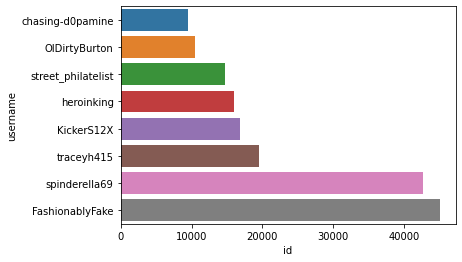

In [28]:
user_counts = users_df.groupby("username").count().sort_values("id").reset_index()
sns.barplot(y="username", x="id", data=user_counts, orient="h")
plt.show()

In [29]:
user_counts

,username,text,subreddit,is_sub,id,spacy
0,chasing-d0pamine,9557,9557,9557,9557,9557
1,OlDirtyBurton,10490,10490,10490,10490,10490
2,street_philatelist,14744,14744,14744,14744,14744
3,heroinking,16051,16051,16051,16051,16051
4,KickerS12X,16885,16885,16885,16885,16885
5,traceyh415,19546,19546,19546,19546,19546
6,spinderella69,42653,42653,42653,42653,42653
7,FashionablyFake,45008,45008,45008,45008,45008


## Sample Data

In [3]:
# generate dataframes of opiate data
n_samples = 100000
samp_query = COLL.aggregate([{ "$sample": {"size": n_samples} }])
samp_df = pd.DataFrame(list(samp_query))
full_df = pd.DataFrame(list(COLL.find({})))
sub_df = full_df.loc[full_df.is_sub == True, :]

In [4]:
# format dataframe
samp_df["year"] = samp_df.time.apply(lambda x: str(x.year))
full_df["year"] = full_df.time.apply(lambda x: str(x.year))
sub_df["year"] = sub_df.time.apply(lambda x: str(x.year))
full_df["lower_text"] = full_df["text"].apply(lambda x: str(x).lower())

/Users/cccdenhart/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Date Distributions

In [5]:
full_df["date"] = full_df.time.apply(lambda ts: date(ts.year, ts.month, ts.day))
date_groups = full_df.groupby("date").count().reset_index()

In [ ]:
df_19 = date_groups.loc[date_groups["date"] >= date(2019, 1, 1), :]
sns.barplot(x="date", y="hash", data=df_19)

## Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

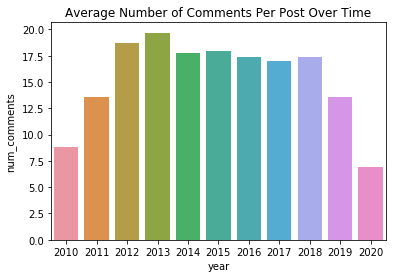

In [40]:
comm_df = sub_df.loc[:,["year", "num_comments"]].dropna().groupby("year")\
                                                .mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

## Active Number of Users on R/Opiates Over Time

In [18]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "username"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

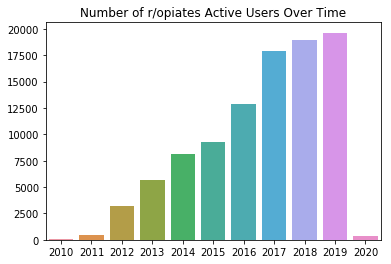

In [19]:
years, user_counts = users_per_year(full_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Number of Posts Over Time

### 1. Count of Submissions Over Time

Text(0.5, 1.0, 'Number of r/opiates Submissions Over Time')

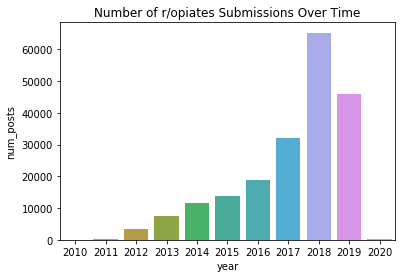

In [39]:
count_df = sub_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Submissions Over Time")

### 2. Count of Submissions + Comments Over Time

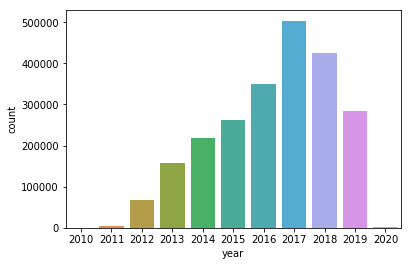

In [21]:
# group by year
query_str = { 
    "$group": { 
        "_id": { 
            "year": {"$year": "$time"}}, 
        "count": {
            "$sum": 1
        },
        "subs": {"$sum": 1}
    }
}
query = COLL.aggregate([query_str])

# extract data
query_li = list(query)
years = [str(it["_id"]["year"]) for it in query_li]
counts = [it["count"] for it in query_li]

# create dataframe
df = pd.DataFrame({"year": years, "count": counts})

# plot
sns.barplot(x="year", y="count", data=df)

## 3. Count of Submissions + Real Comments

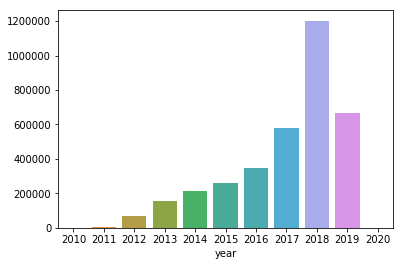

In [55]:
sub_df.query("year == '2017'").shape[0]
comms = sub_df.groupby("year")["num_comments"].sum().tolist()
subs = sub_df.groupby("year").count()
combined = [a + b for a, b in zip(comms, subs["hash"].tolist())]
sns.barplot(x=subs.index, y=combined)

In [57]:
comm_counts = full_df.groupby("parent_id").count().reset_index()
comm_counts["new_par_id"] = comm_counts["parent_id"].apply(lambda x: x.replace("t1_", ""))

In [66]:
sub_df.merge(comm_counts, how="inner", left_on="pid", right_on="new_par_id")

,_id_x,hash_x,is_sub_x,num_comments_x,parent_id_x,pid_x,subr_x,text_x,time_x,title_x,...,num_comments_y,pid_y,subr_y,text_y,time_y,title_y,username_y,year_y,date,new_par_id


In [69]:
sub_df.query("pid == '1a0j42'")

,_id,hash,is_sub,num_comments,parent_id,pid,subr,text,time,title,username,year
120603,5e45fa48d9fddf046af68b7c,8711508881785506729,True,4.0,NaN,1a0j42,opiates,I did ~.5 mg about 30 mins ago. I feel alright...,2013-03-10 11:04:42,Suboxone,istealbarbeques,2013


In [70]:
comm_counts.head()

,parent_id,_id,hash,is_sub,num_comments,pid,subr,text,time,title,username,year,date,new_par_id
0,t1_c0pfopy,1,1,1,0,1,1,1,1,0,1,1,1,c0pfopy
1,t1_c0pjl4r,2,2,2,0,2,2,2,2,0,2,2,2,c0pjl4r
2,t1_c0pk1zn,2,2,2,0,2,2,2,2,0,2,2,2,c0pk1zn
3,t1_c0puy8n,1,1,1,0,1,1,1,1,0,1,1,1,c0puy8n
4,t1_c0pwvyk,1,1,1,0,1,1,1,1,0,1,1,1,c0pwvyk


## Word Usage Over Time

In [78]:
def word_per_year(df: pd.DataFrame, words: List[str], user_counts: List[int]) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda year: df.loc[df.year == year, "lower_text"].apply(check_in).sum()
    word_counts: List[int] = [countw(year) for year in years]
    wc_norm: List[float] = [w / u for w, u in zip(word_counts, user_counts)]
    return pd.DataFrame({"years": years, "word_counts": word_counts, "wc_norm": wc_norm})

def append_wc(df: pd.DataFrame, words: List[List[str]], user_counts: List[int]) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, user_counts)), words, pd.DataFrame())
    nyear = df.year.unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df

### 1. Word Count by Location

In [83]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
loc_words = [["boston", "beantown", "bos"], ["lawrence"], ["lowell"], ["manchester"], ["worcester"]]
loc_df = append_wc(full_df, loc_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

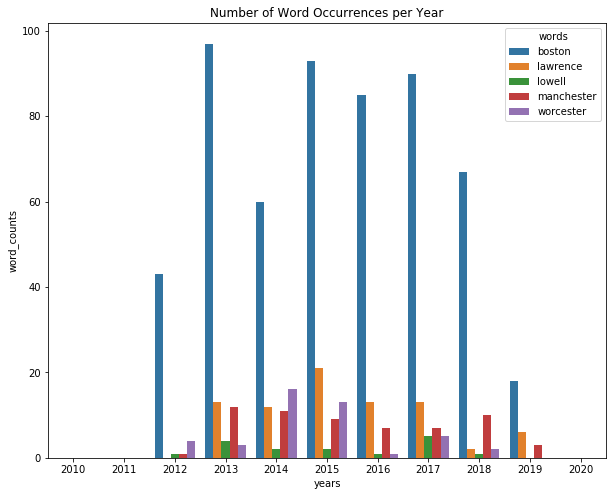

In [84]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=wc_df)
ax.set_title(f"Number of Word Occurrences per Year")

### 2. Drug Count by Location

In [85]:
drug_words = [["fentanyl", "fent", "fenty"], ["heroin"]]
drug_df = append_wc(full_df, drug_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

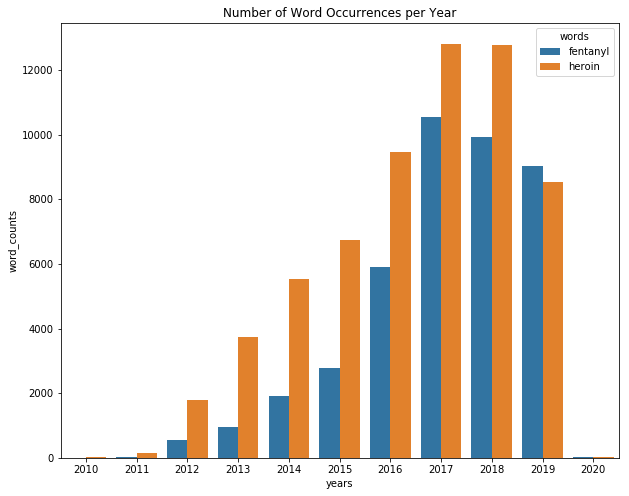

In [86]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=drug_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Spacy Location Extraction

In [7]:
# process text with spacy
text = full_df.text.dropna().tolist()
n_samples = 100000
samp_text = random.sample(text, n_samples)
docs = []
for i in tqdm(range(len(text))):
    docs.append(nlp(text[i]))

 19%|█▉        | 419475/2217650 [15:13:34<11:16:06, 44.33it/s]     

KeyboardInterrupt: 

In [ ]:
# extract location entities
ents = ft.reduce(lambda acc, d: acc + list(d.ents), docs, [])
gpes = [e for e in ents if e.label_ == "GPE"]

In [ ]:
# display a frequency table of GPEs
gpe_counts = pd.Series(gpes).apply(lambda x: str(x)).value_counts()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(gpe_counts)

In [ ]:
("chitown" in gpe_counts or "Chitown" in gpe_counts or "chi-town" in gpe_counts or "Chi-town" in gpe_counts)

In [ ]:
"Chicago" in gpe_counts

In [ ]:
gpe_counts.to_csv("./entity_counts.csv")

 19%|█▉        | 419475/2217650 [15:13:51<11:16:06, 44.33it/s]

## Frequency Table

In [36]:
freq_df = pd.DataFrame(list(COLL.find({})))
freq_df["year"] = freq_df.time.apply(lambda x: str(x.year))

In [37]:
freq_df["Threads"] = freq_df["is_sub"].apply(lambda x: 1 if x else 0)
freq_df["Comments"] = freq_df["is_sub"].apply(lambda x: 1 if (not x) else 0)
freq_df["Totals"] = [1] * freq_df.shape[0]
count_df = freq_df.groupby("year").sum().loc[:,["Threads", "Comments", "Totals"]]

In [89]:
count_df

,year,num_posts
0,2010,42
1,2011,268
2,2012,3397
3,2013,7642
4,2014,11462
5,2015,13701
6,2016,18822
7,2017,32046
8,2018,65269
9,2019,45922
